In [1]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')



def create_model(columnm, epoch):
    
#     if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column)):
#         os.makedirs('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))

#     if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column)):
#         os.makedirs('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))

    LOG_PATH = Path('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))
    DATA_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/')
    LABEL_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/')
    OUTPUT_PATH = Path('/scratch/da2734/twitter/mturk_mar6/output_binary_pos_neg_balanced_{}'.format(column))
    FINETUNED_PATH = None

    args = Box({
        "run_text": "labor mturk ar 6 binary",
        "train_size": -1,
        "val_size": -1,
        "log_path": LOG_PATH,
        "full_data_dir": DATA_PATH,
        "data_dir": DATA_PATH,
        "task_name": "labor_market_classification",
        "no_cuda": False,
        #     "bert_model": BERT_PRETRAINED_PATH,
        "output_dir": OUTPUT_PATH,
        "max_seq_length": 512,
        "do_train": True,
        "do_eval": True,
        "do_lower_case": True,
        "train_batch_size": 8,
        "eval_batch_size": 16,
        "learning_rate": 5e-5,
        "num_train_epochs": 100,
        "warmup_proportion": 0.0,
        "no_cuda": False,
        "local_rank": -1,
        "seed": 42,
        "gradient_accumulation_steps": 1,
        "optimize_on_cpu": False,
        "fp16": False,
        "fp16_opt_level": "O1",
        "weight_decay": 0.0,
        "adam_epsilon": 1e-8,
        "max_grad_norm": 1.0,
        "max_steps": -1,
        "warmup_steps": 500,
        "logging_steps": 50,
        "eval_all_checkpoints": True,
        "overwrite_output_dir": True,
        "overwrite_cache": True,
        "seed": 42,
        "loss_scale": 128,
        "task_name": 'intent',
        "model_name": 'bert-base-uncased',
        "model_type": 'bert'
    })

    import logging

    logfile = str(LOG_PATH / 'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
        ])

    logger = logging.getLogger()

    logger.info(args)

    device = torch.device('cuda')
    if torch.cuda.device_count() > 1:
        args.multi_gpu = True
    else:
        args.multi_gpu = False

    label_cols = ['pos']

    databunch = BertDataBunch(
        args['data_dir'],
        LABEL_PATH,
        args.model_name,
        train_file='train_{}.csv'.format(column),
        val_file='val_{}.csv'.format(column),
        label_file='label_{}.csv'.format(column),
        # test_data='test.csv',
        text_col="text",  # this is the name of the column in the train file that containts the tweet text
        label_col=label_cols,
        batch_size_per_gpu=args['train_batch_size'],
        max_seq_length=args['max_seq_length'],
        multi_gpu=args.multi_gpu,
        multi_label=False,
        model_type=args.model_type)

    num_labels = len(databunch.labels)
    print('num_labels', num_labels)

    print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')

    # metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
    metrics = []
    # metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
    # metrics.append({'name': 'roc_auc', 'function': roc_auc})
    # metrics.append({'name': 'fbeta', 'function': fbeta})
    metrics.append({'name': 'accuracy', 'function': accuracy})
    metrics.append({'name': 'roc_auc_save_to_plot_binary', 'function': roc_auc_save_to_plot_binary})
    # metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})

    learner = BertLearner.from_pretrained_model(
        databunch,
        pretrained_path='../mturk_mar6/output_binary_pos_neg_balanced_{}/model_out_{}/'.format(column, epoch), 
        metrics=metrics,
        device=device,
        logger=logger,
        output_dir=args.output_dir,
        finetuned_wgts_path=FINETUNED_PATH,
        warmup_steps=args.warmup_steps,
        multi_gpu=args.multi_gpu,
        is_fp16=args.fp16,
        multi_label=False,
        logging_steps=0)
    
    return learner

/home/da2734/miniconda3/envs/worldbank/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
# histograms compute
import pickle
best_epochs = {
    'is_hired_1mo':12,
    'lost_job_1mo':14,
    'job_offer':7,
    'is_unemployed':10,
    'job_search':7
}

all_pred = {}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column, best_epochs[column])
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    val = pd.read_csv('/scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/val_{}.csv'.format(column))
    print(val.shape)
    # start_time = time.time()
    texts = val['text'].values.tolist()
#     print(len(texts))
    predictions = trained_model.predict_batch(texts)
#     print(predictions)
    print('inference:', str(time.time() - start_time), 'seconds on ', len(texts), 'tweets')

    prediction_df = pd.DataFrame(
    [dict(prediction) for prediction in predictions],
        index=val.id
        ).rename(columns={
        'pos':'pos_model',
        'neg':'neg_model',
    #     'is_hired_1mo':'is_hired_1mo_model',
    #     'lost_job_1mo':'lost_job_1mo_model',
    #     'job_offer"':'job_offer_model',
        }
    )
        
    merged = prediction_df.merge(val, on='id')
    print(merged.head())
    
    all_pred[column] = merged
#     break

pickle.dump( all_pred, open( "./all_pred_8.2.pkl", "wb" ) )


is_unemployed
04/11/2020 16:38:06 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_pos_neg_balanced_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval

04/11/2020 16:38:29 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/11/2020 16:38:29 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/cache/cached_bert_train_multi_class_512_train_job_search.csv
04/11/2020 16:38:29 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/cache/cached_bert_dev_multi_class_512_val_job_search.csv
num_labels 2
time taken to load all this stuff: 97.97850847244263 seconds
04/11/2020 16:38:29 - INFO - transformers.configuration_utils -   loading configuration file ../mturk_mar6/output_binary_pos_neg_balanced_job_search/model_out_7/config.json
04/11/2020 16:38:29 - 

04/11/2020 16:38:39 - INFO - transformers.tokenization_utils -   loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/da2734/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
04/11/2020 16:38:40 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/cache/cached_bert_train_multi_class_512_train_job_offer.csv
04/11/2020 16:38:40 - INFO - root -   Loading features from cached file /scratch/da2734/twitter/mturk_mar6/data_binary_pos_neg_balanced/cache/cached_bert_dev_multi_class_512_val_job_offer.csv
num_labels 2
time taken to load all this stuff: 108.63996362686157 seconds
04/11/2020 16:38:40 - INFO - transformers.configuration_utils -   loading configuration file ../mturk_mar6/output_binary_pos_neg_balanced_job_offer/model_out_7/config.json
04/11/2020 16:38:40 - IN

is_unemployed
lost_job_1mo
job_search
is_hired_1mo
job_offer


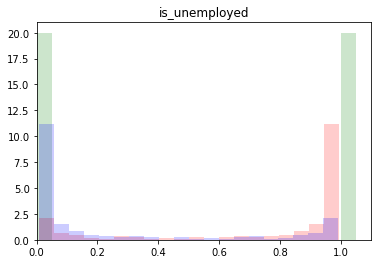

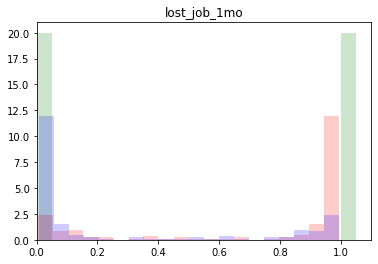

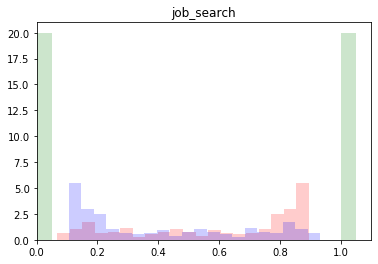

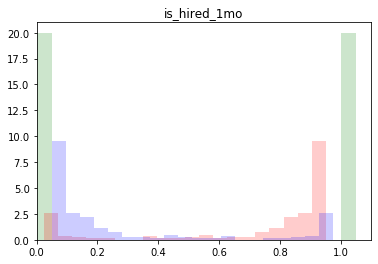

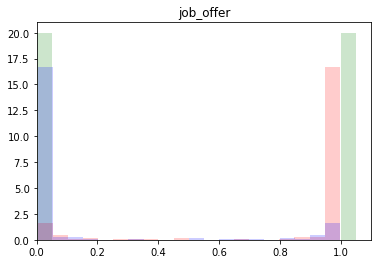

In [8]:
# histograms plot

import pickle

# with open("./all_pred_8.2.pkl", 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_pred = pickle.load(f)


for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    merged = all_pred[column]
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged['pos'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)

    plt.hist(merged['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['neg_model'], bins=20, density = True, color = 'blue', alpha = 0.2)
#     ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
#     ax.legend()
    plt.xlim(0,1.1)
    
    merged.to_csv('merged_{}.csv'.format(column))

#     plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))

In [ ]:
# preparing ROC using learner.validate()
ROC_dict = {}

best_epochs = {
    'is_hired_1mo':12,
    'lost_job_1mo':14,
    'job_offer':7,
    'is_unemployed':10,
    'job_search':7
}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column, best_epochs[column])
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    trained_model.validate()    
#     print(val.shape)
    # start_time = time.time()
#     texts = val['text'].values.tolist()
#     print(len(texts))
#     predictions = trained_model.predict_batch(texts)
    # predictions.head()
    print('validation:', str(time.time() - start_time), 'seconds')   
    
    output = pickle.load( open( "/scratch/da2734/twitter/8-boundary-classified/roc_auc_save_to_plot_binary.pkl", "rb" ) )

    ROC_dict[column] = output
    
#     break

pickle.dump( ROC_dict, open( "./ROC_dict_8.2.pkl", "wb" ) )

In [ ]:
# ROC plot from learner.validate()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# with open("./ROC_dict_8.2.pkl", 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     ROC_dict = pickle.load(f)

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    
    fpr = ROC_dict[column]['fpr']
#     print(fpr)
    tpr = ROC_dict[column]['tpr']
    thresholds = ROC_dict[column]['thresholds']
#     print(thresholds)
#     print(fpr["micro"])
#     print(len(fpr["micro"]), len(thresholds))
    roc_auc = ROC_dict[column]['roc_auc']

    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(column, roc_auc["micro"]))
#     plt.annotate(thresholds, (fpr["micro"], tpr["micro"]))

    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%20 == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

    plt.show()    

#     break
    

In [ ]:
merged = all_pred['is_unemployed']
merged

In [ ]:
# ROC plot using predicted values on validation set directly i.e. not through validation

import pickle

# with open("./all_pred_8.2.pkl", 'rb') as f:
#     # The protocol version used is detected automatically, so we do not
#     # have to specify it.
#     all_pred = pickle.load(f)


for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    merged = all_pred[column]
    print(merged.head())

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = merged['pos']
    y_pred = merged['pos_model']

#    print(y_true)
    # Compute micro-average ROC curve and ROC area
 
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
#     print('fpr["micro"]', fpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(fpr["micro"])
    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(column, roc_auc["micro"]))
    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%20 == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

    plt.show()    


    break
    
# merged.head()

In [ ]:
# confusion matrix

import seaborn as sn
from matplotlib.colors import ListedColormap

thresholds_dict = {
    'is_unemployed': 0.16,
    'lost_job_1mo':  0.03,
    'job_search':  0.067,  
    'is_hired_1mo':  0.02,
    'job_offer':     0.111,
}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
# for column in ["job_offer"]:
    merged = all_pred[column]
    merged['neg'] = abs(1-merged['pos'])
#     merged
    threshold = thresholds_dict[column]
#     print(threshold)
    
#     print(merged.loc[merged['pos_model'] > 0.9])
    TP = np.sum(merged.loc[merged['pos_model'] > threshold, 'neg'])
    FP = np.sum(merged.loc[merged['pos_model'] > threshold, 'pos'])
    TN = np.sum(merged.loc[merged['pos_model'] < threshold, 'neg'])
    FN = np.sum(merged.loc[merged['pos_model'] < threshold, 'pos'])
#     TN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
#     FN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
    
    total = sum([TP, FP, TN, FN]) 
#     print(threshold, TP/total, FP/total, TN/total, FN/total, total)
    print(column, threshold, 'TPR:', TP/(TP+FN), 'FPR:', FP/(FP+TN), total)

    confusion_matrix = np.array([
                                [TN/total, FN/total],
                                [FP/total, TP/total]
                                ])
    labels =           np.array([
                                ['TN', 'FN'],
                                ['FP', 'TP']
                                ])
    
    labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(labels.flatten(),
                                               confusion_matrix.flatten())])
         ).reshape(2, 2)
#     print(labels)
    
    fig, ax = plt.subplots(1)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(confusion_matrix, annot=labels, fmt="", cbar=False)
    ax.set(xlabel='Actual', ylabel='Predicted')
    plt.title(column)
    
#     break

# load from pickles
# why am I getting different results between ROC curve and confusion matrices at the same thresholds?

In [ ]:
for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    model_output = all_pred[column]
    model_output['flip_pos_model'] = model_output['pos_model']
    model_output['flip_neg_model'] = model_output['neg_model']

    neg_sorted = model_output.sort_values(by=['flip_neg_model'], ascending = False)
    pos_sorted = model_output.sort_values(by=['flip_pos_model'], ascending = False)

    print('\n\n\n------ ', column)
    print('<<<< top 10 positive >>>> max prob:', max(model_output['flip_pos_model']))
    print(pos_sorted['text'][:5])
    print('\n<<<< top 10 neg >>>> max prob:', max(model_output['flip_neg_model']))
    print(neg_sorted['text'][:5])

#     break
    
# pos_sorted